In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
Kyoto_Gases = pd.read_csv('Kyoto Gases.csv')


In [3]:
#Save variable Kyoto_Gases data for the period 2020-2100 (ten-year interval), considering only C1-C8 cases for simplicity.
X_Emissions = Kyoto_Gases.iloc[:,3:-1]
X_Emissions = X_Emissions[X_Emissions['Category'].isin(['C1','C2','C3','C4','C5','C6','C7','C8'])]
X_Emissions.reset_index(drop=True,inplace=True)


In [4]:
#Normalize the data
def normalize_time_series(data):
    return (data - np.mean(data, axis=1).reshape(-1, 1)) / np.std(data, axis=1).reshape(-1, 1)

In [5]:
X_Emissions_Variables = X_Emissions.iloc[:,:-1].values
X_Emissions_normalized = normalize_time_series(X_Emissions_Variables)

In [6]:
from tslearn.metrics import dtw, cdist_dtw
Emissions_distance_matrix = np.load('KyotoGasesMatrix.npy')
#'KyotoGasesMatrix.npy 'saves the previously calculated matrix because it takes a lot of time to repeatedly calculate this matrix. Or you can use cdist_dtw (X_Emissions_normalized) to recalculate

C:\Users\l1137\.conda\envs\DeepIAM\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\l1137\.conda\envs\DeepIAM\lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\l1137\.conda\envs\DeepIAM\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


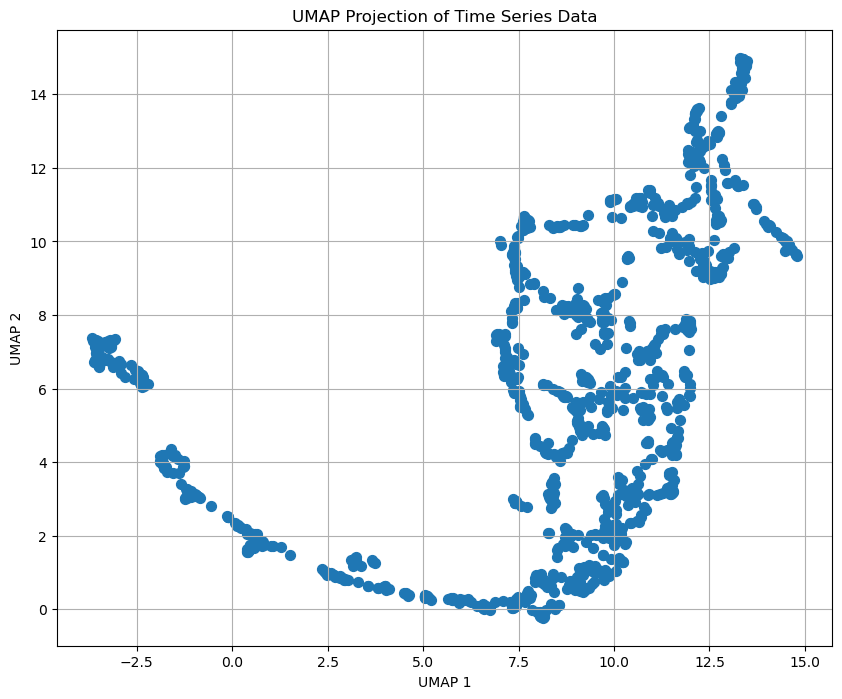

In [7]:
#Dimension reduction is achieved through UMAP method.
import umap
#UMP Embedding
embedding = umap.UMAP(n_neighbors=15, metric='precomputed', random_state=30).fit_transform(Emissions_distance_matrix)
# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=50)
plt.title("UMAP Projection of Time Series Data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

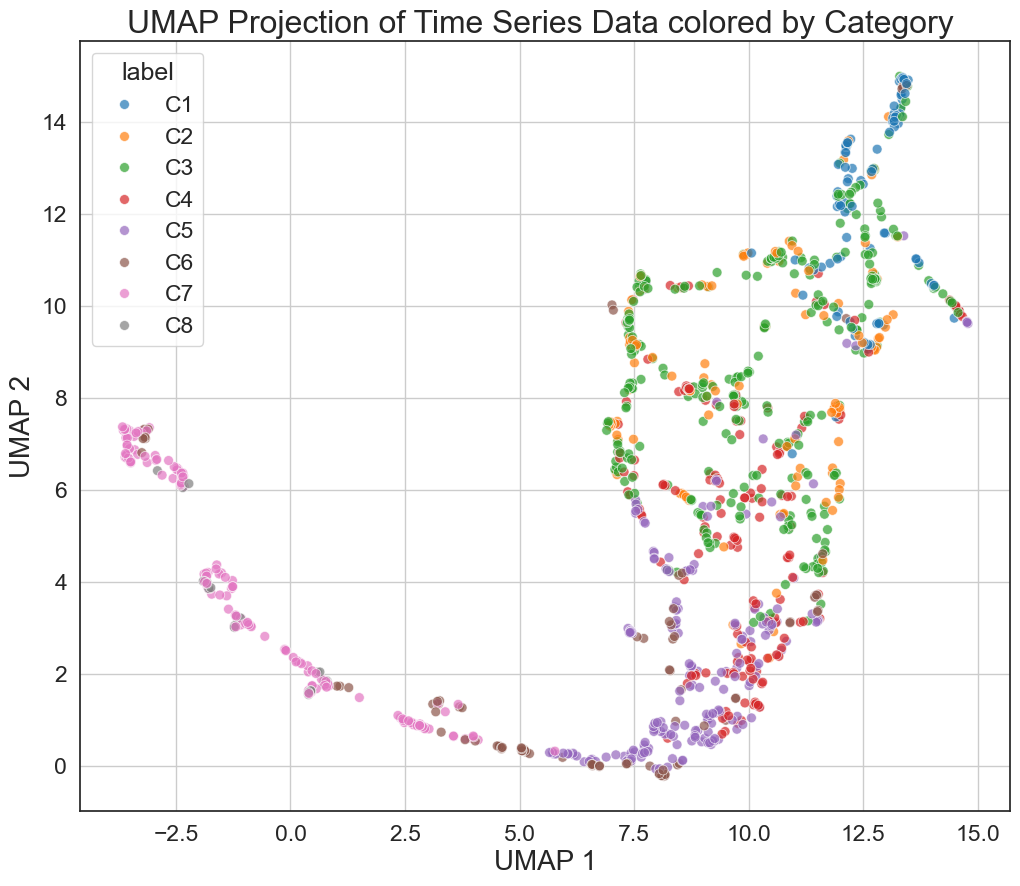

In [8]:
#Distribution of data points after dimensionality reduction
import seaborn as sns
# Create a DataFrame from embeddings and labels
df = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
order = ['C1','C2','C3','C4','C5','C6','C7','C8']
df['label'] = X_Emissions['Category']  
# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# Use Seaborn to create the scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2', hue='label', palette='tab10', edgecolor='w', s=50, alpha=0.7,hue_order=order)
plt.xlabel('UMAP 1', fontsize=20)
plt.ylabel('UMAP 2', fontsize=20)
plt.grid(True)
plt.title("UMAP Projection of Time Series Data colored by Category ",fontsize=23)
plt.savefig('Figure S1.pdf',format='pdf',bbox_inches='tight')
plt.show()

C:\Users\l1137\.conda\envs\DeepIAM\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\l1137\.conda\envs\DeepIAM\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


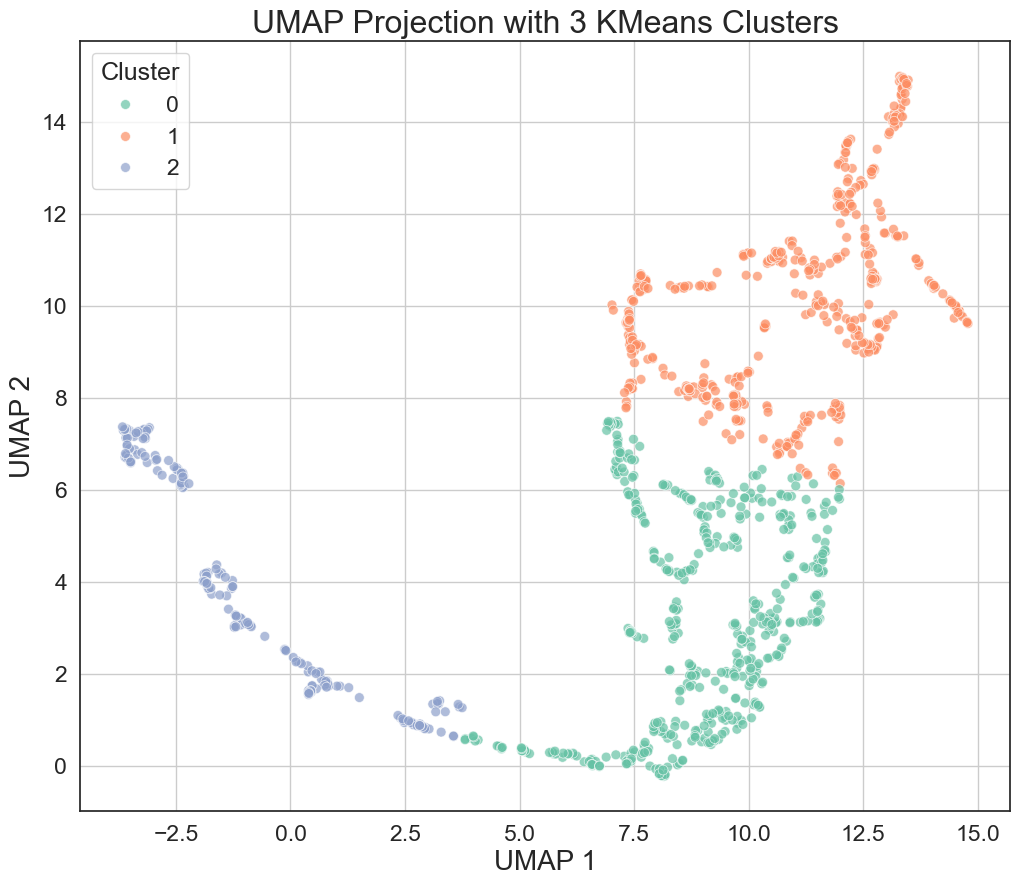

In [9]:
#Clustering based on Kyoto_Gases UMAP results
from sklearn.cluster import KMeans

# Define the number of clusters you want. For instance, if you want 3 clusters:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(embedding)

# The DataFrame now has an additional column named 'Cluster' with cluster labels.
# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='UMAP 1', y='UMAP 2', hue='Cluster', palette='Set2', edgecolor='w', s=50, alpha=0.7)
plt.xlabel('UMAP 1', fontsize=20)
plt.ylabel('UMAP 2', fontsize=20)
plt.grid(True)
plt.title(f"UMAP Projection with {n_clusters} KMeans Clusters",fontsize=23)
plt.show()

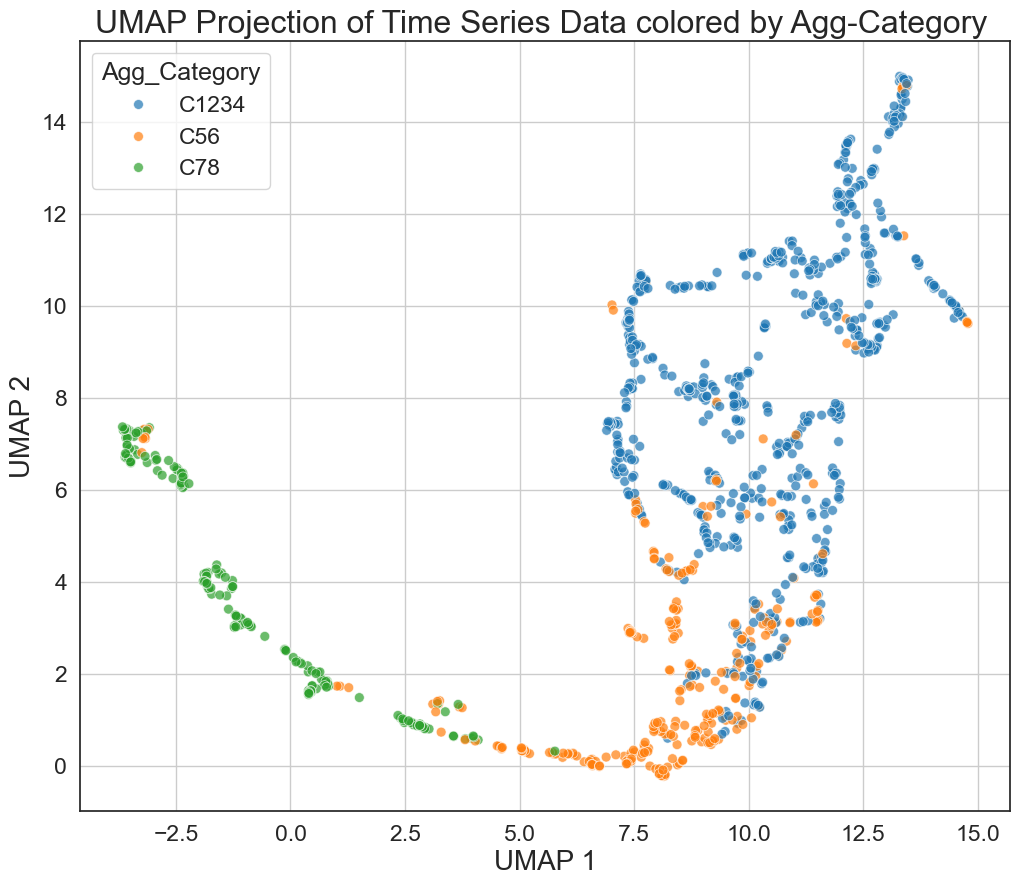

In [10]:
#Merge C1 C2 C3 C4 into a class of C1234,  C5 C6 into a class of C56, and C7 C8 into a class of C78 for analysis.
#Distribution of data points
mapping = {'C1':'C1234','C2':'C1234','C3':'C1234','C4':'C1234','C5':'C56','C6':'C56','C7':'C78','C8':'C78'}
order = ['C1234','C56','C78']
df_class_merge = pd.DataFrame(embedding, columns=['UMAP 1', 'UMAP 2'])
df_class_merge['Agg_Category']= X_Emissions['Category'].replace(mapping)
# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
# Use Seaborn to create the scatter plot
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_class_merge, x='UMAP 1', y='UMAP 2', hue='Agg_Category', palette='tab10', edgecolor='w', s=50, alpha=0.7,hue_order=order)
plt.xlabel('UMAP 1', fontsize=20)
plt.ylabel('UMAP 2', fontsize=20)
plt.grid(True)
plt.title("UMAP Projection of Time Series Data colored by Agg-Category ",fontsize=23)
plt.savefig('Agg-Category.pdf',format='pdf')
plt.show()

C:\Users\l1137\.conda\envs\DeepIAM\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\l1137\.conda\envs\DeepIAM\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


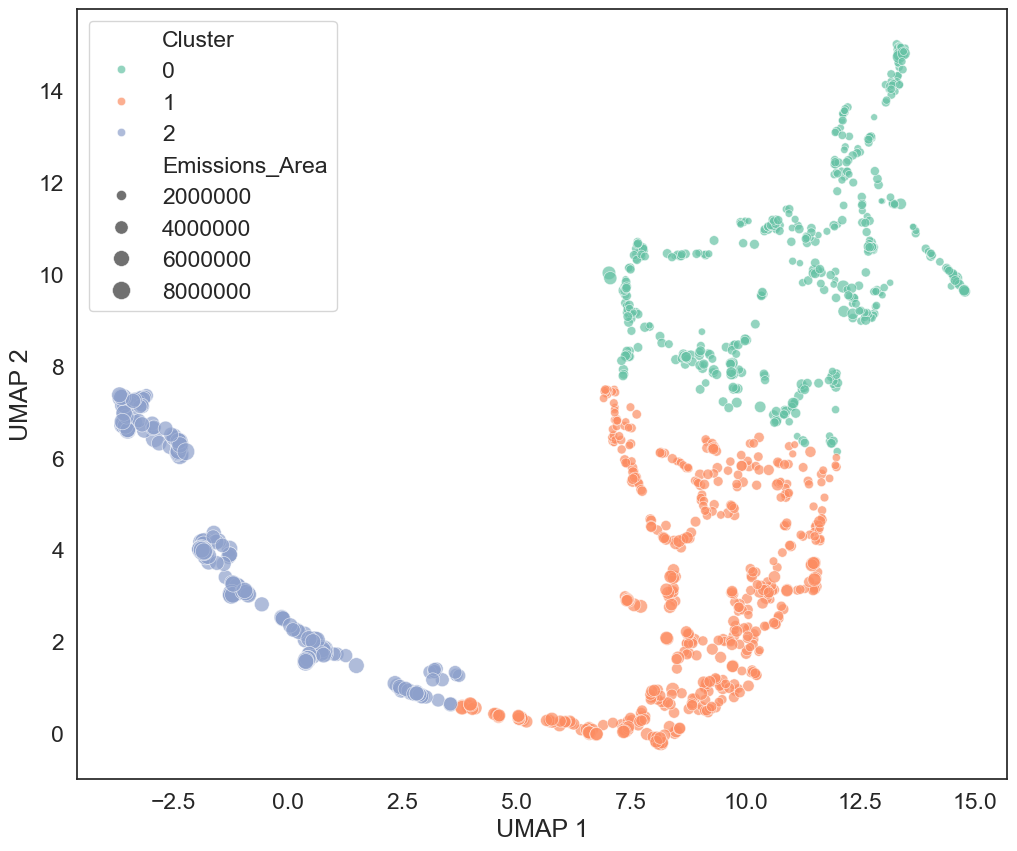

In [11]:
#Determine the size of the point based on Kyoto_Gases emissions
Emissions_Area = np.zeros(len(X_Emissions))
for i in range(len(X_Emissions)):
    for j in range(8):
        Emissions_Area[i] +=(X_Emissions_Variables[i][j] + X_Emissions_Variables[i][j+1]) * 5
        
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_class_merge['Cluster'] = kmeans.fit_predict(embedding)# The DataFrame now has an additional column named 'cluster' with cluster labels.
df_class_merge['Cluster'].replace({1:0,0:1},inplace=True)#The order of swapping tags makes the image more natural
df_class_merge['Emissions_Area'] = Emissions_Area

# Set Seaborn style and context
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.figure(figsize=(12, 10))

sns.scatterplot(data=df_class_merge, x='UMAP 1', y='UMAP 2', hue='Cluster', palette='Set2', edgecolor='w', size='Emissions_Area', alpha=0.7,
                sizes=(20,200))

plt.savefig('UMAP.pdf',format='pdf')
plt.show()

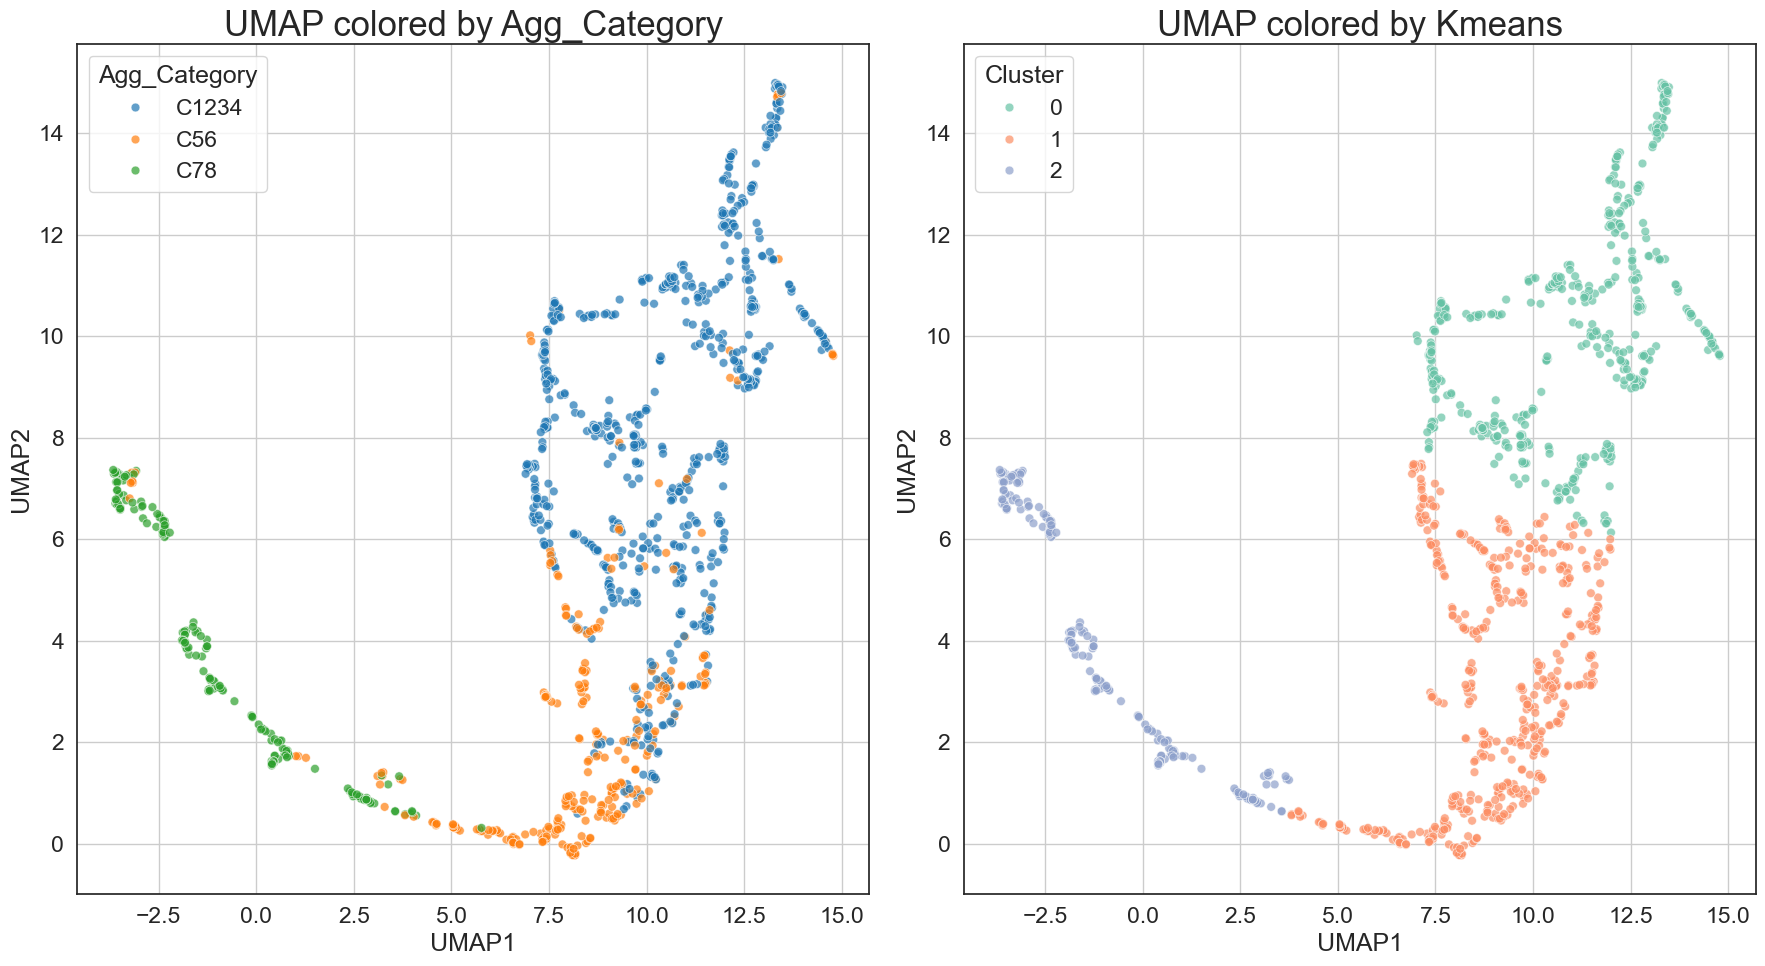

In [12]:
#True class distribution image and cluster distribution image
# Convert embeddings to DataFrame for visualization
df_embedding = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
mapping = {'C1':'C1234','C2':'C1234','C3':'C1234','C4':'C1234','C5':'C56','C6':'C56','C7':'C78','C8':'C78'}
order = ['C1234','C56','C78']
df_embedding['Agg_Category'] = X_Emissions['Category'].replace(mapping)
df_embedding['Cluster'] = df_class_merge['Cluster']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Plot True Class distribution image
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Agg_Category', ax=axes[0], palette='tab10',alpha=0.7, s=40,hue_order=order)
axes[0].set_title('UMAP colored by Agg_Category',fontsize=25)
axes[0].grid()


# Plot Cluster distribution image
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Cluster', ax=axes[1], palette='Set2', alpha=0.7, s=40)
axes[1].set_title('UMAP colored by Kmeans',fontsize=25)
axes[1].grid()
plt.tight_layout()
plt.show()

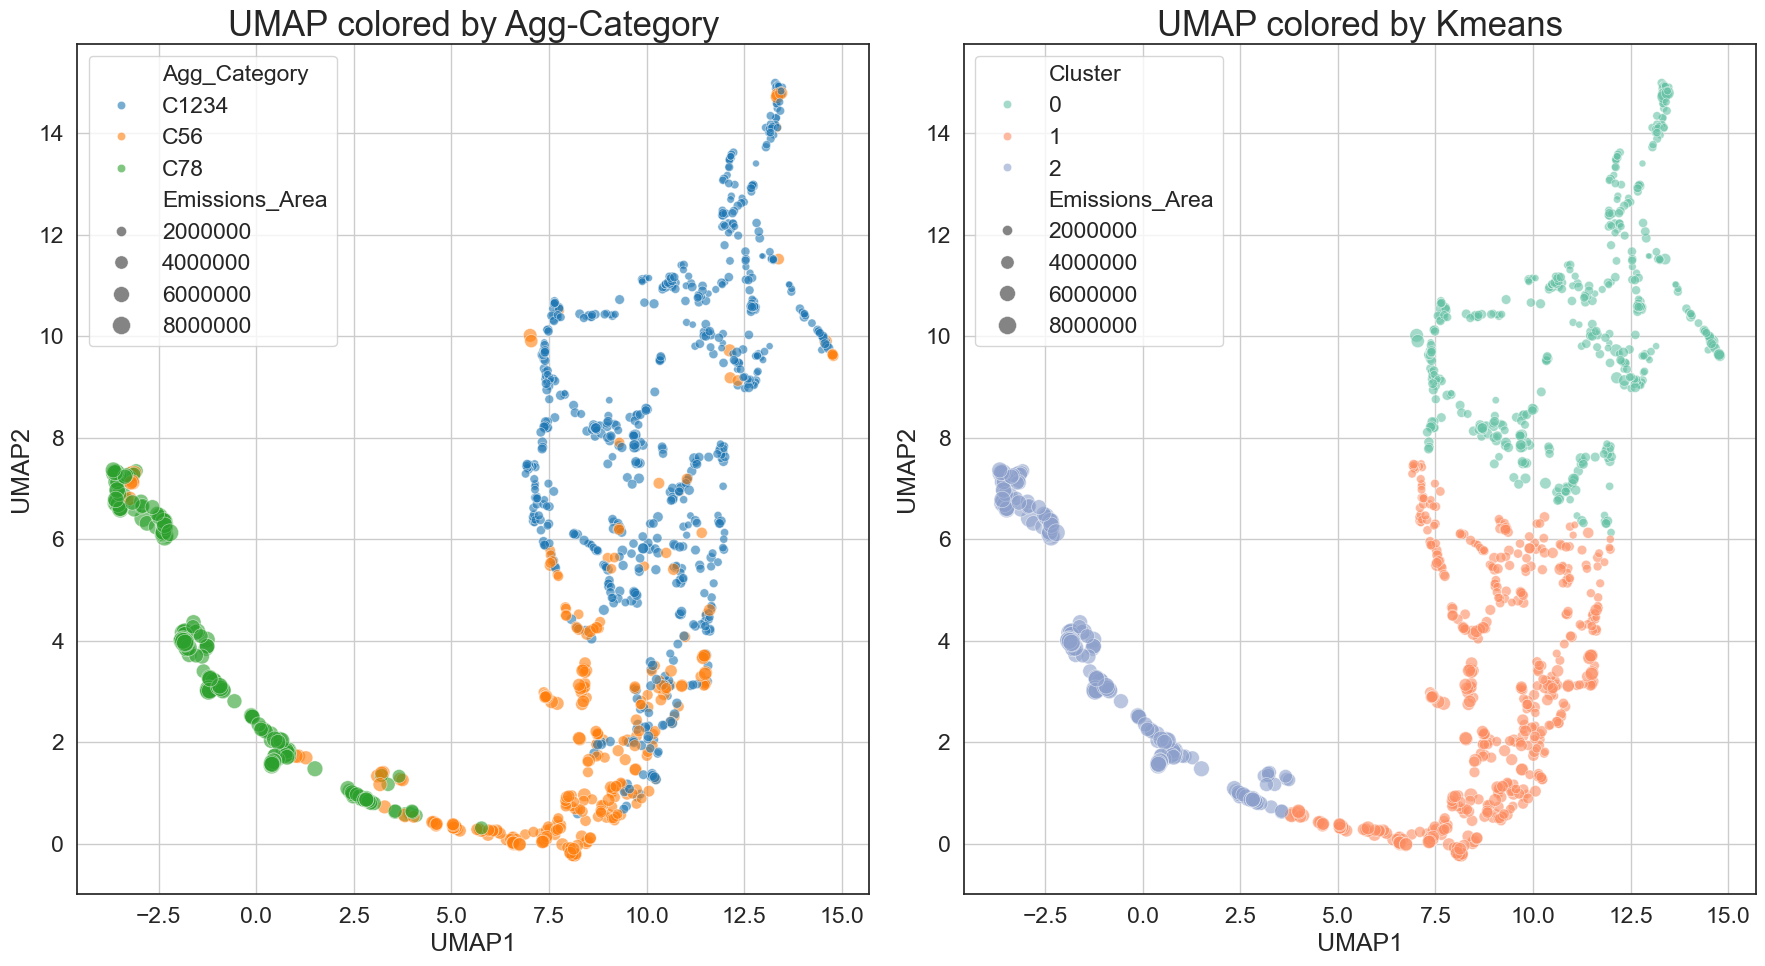

In [13]:
#Determine the size of the point based on Kyoto_Gases emissions
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
df_embedding['Emissions_Area'] = Emissions_Area
# True Agg-Category
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Agg_Category', ax=axes[0], palette='tab10', alpha=0.6, size= 'Emissions_Area',hue_order=order
               ,sizes=(20,200))
axes[0].set_title('UMAP colored by Agg-Category',fontsize=25)
axes[0].grid()

# Cluster distribution
sns.scatterplot(data=df_embedding, x='UMAP1', y='UMAP2', hue='Cluster', ax=axes[1], palette='Set2', alpha=0.6, size= 'Emissions_Area',sizes=(20,200))
axes[1].set_title('UMAP colored by Kmeans',fontsize=25)
axes[1].grid()
plt.tight_layout()
plt.savefig('Kmeans.pdf',format='pdf',bbox_inches='tight')
plt.show()


In [14]:
#Plot emission curves for Kyoto_Gases under different classes and clusters.
X_Emissions['Agg_Category'] = df_class_merge['Agg_Category']
X_Emissions['Cluster'] = df_class_merge['Cluster']
long_df_Cluster = X_Emissions.drop(columns=['Category','Agg_Category']).melt(id_vars='Cluster', var_name='time', value_name='value')
long_df_Agg_Category = X_Emissions.drop(columns=['Category','Cluster']).melt(id_vars='Agg_Category', var_name='time', value_name='value')

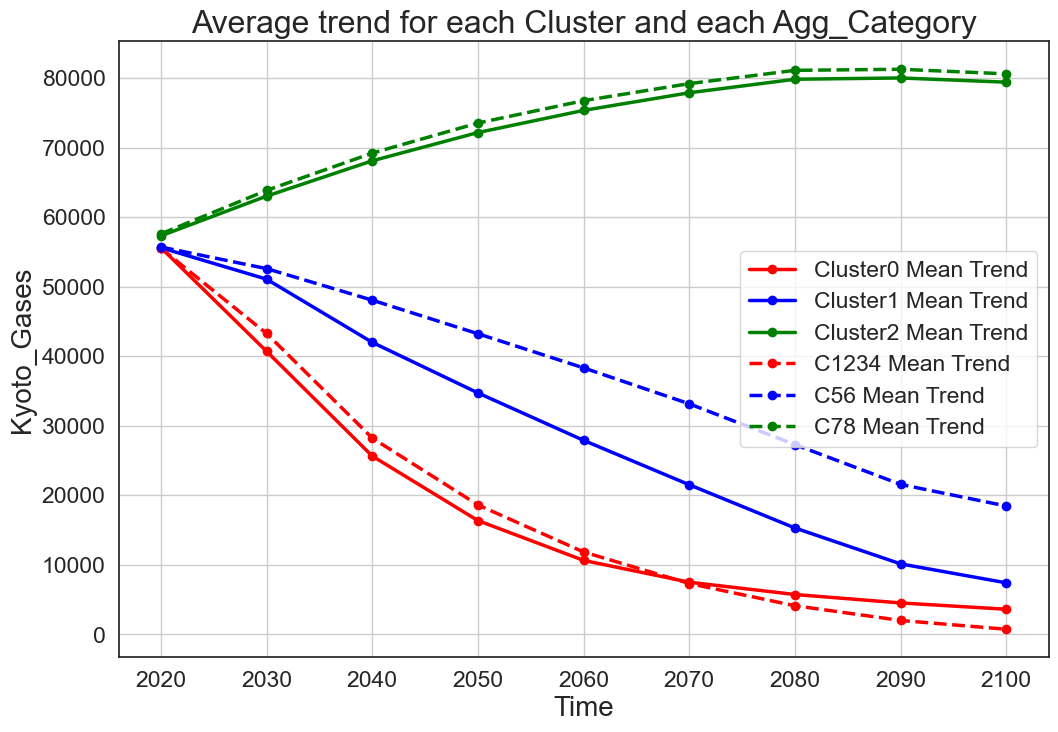

In [15]:
# plt.figure(figsize=(12,8))
# colors = ['red', 'blue', 'green']
# for i in range(3):
#     Category_data = long_df_Cluster[long_df_Cluster['Cluster'] == i]
#     stats = Category_data.groupby('time').agg(mean=('value', 'mean')).reset_index()
#     plt.plot(stats['time'], stats['mean'], color=colors[i], label=f'Cluster{i} Mean Trend',linestyle='-',marker='o')
# Agg_Categories = ['C1234','C56','C78']
# for i,Agg_Category in enumerate(Agg_Categories) :
#     Category_data = long_df_Agg_Category[long_df_Agg_Category['Agg_Category'] == Agg_Category]
#     stats = Category_data.groupby('time').agg(mean=('value', 'mean')).reset_index()
#     plt.plot(stats['time'], stats['mean'], color=colors[i], label=f'{Agg_Category} Mean Trend',linestyle='--',marker='o')

# plt.xlabel('Time', fontsize=20)
# plt.ylabel('Kyoto_Gases', fontsize=20)
# plt.grid(True)
# plt.title(f"Average trend for each Cluster and each Agg_Category",fontsize=23)
# plt.savefig('Average trend for each Cluster and each Agg_Category.pdf',format='pdf',bbox_inches='tight')
# plt.legend()
# plt.show()
plt.figure(figsize=(12,8))
colors = ['red', 'blue', 'green']

# Process Cluster Data and Save
all_cluster_stats = []
for i in range(3):
    Category_data = long_df_Cluster[long_df_Cluster['Cluster'] == i]
    stats = Category_data.groupby('time').agg(mean=('value', 'mean')).reset_index()
    
    # Add Cluster Identity column
    stats['group'] = f'Cluster{i}'
    all_cluster_stats.append(stats)
    
    # Draw curves
    plt.plot(stats['time'], stats['mean'], color=colors[i], 
             label=f'Cluster{i} Mean Trend', linestyle='-', marker='o')

# Merge all Cluster statistics and save
cluster_stats_df = pd.concat(all_cluster_stats, ignore_index=True)
cluster_stats_df.to_csv('cluster_statistics.csv', index=False)

# Process Agg_Category data and save it
all_category_stats = []
Agg_Categories = ['C1234','C56','C78']
for i, Agg_Category in enumerate(Agg_Categories):
    Category_data = long_df_Agg_Category[long_df_Agg_Category['Agg_Category'] == Agg_Category]
    stats = Category_data.groupby('time').agg(mean=('value', 'mean')).reset_index()
    
    # Add Agg_Category ID column
    stats['group'] = Agg_Category
    all_category_stats.append(stats)
    
    # Draw curves
    plt.plot(stats['time'], stats['mean'], color=colors[i], 
             label=f'{Agg_Category} Mean Trend', linestyle='--', marker='o')

# Merge all Agg_Category statistics and save them
category_stats_df = pd.concat(all_category_stats, ignore_index=True)
category_stats_df.to_csv('agg_category_statistics.csv', index=False)

plt.xlabel('Time', fontsize=20)
plt.ylabel('Kyoto_Gases', fontsize=20)
plt.grid(True)
plt.title("Average trend for each Cluster and each Agg_Category", fontsize=23)
plt.legend()

# Save the image
plt.savefig('Average trend for each Cluster and each Agg_Category.pdf', 
            format='pdf', bbox_inches='tight')
plt.show()

In [16]:
#Draw a Sankey diagram to observe the differences between clusters and true categories.
import plotly.graph_objects as go
# Create a DataFrame from Agg_Category and Cluster
df = pd.DataFrame({'Agg_Category': df_class_merge['Agg_Category'], 'Cluster': df_class_merge['Cluster']})

# Count the relationships
count_relationship = df.groupby(['Agg_Category', 'Cluster']).size().reset_index(name='count')

# Create lists for source, target, and value
source = count_relationship['Agg_Category'].astype(str)
target = count_relationship['Cluster'].astype(str)
value = count_relationship['count']

# Create a unique list of Agg_Category and Cluster labels
labels = pd.concat([source, target]).unique().tolist()

# Convert source and target labels to their respective indices
source_indices = source.apply(lambda x: labels.index(x))
target_indices = target.apply(lambda x: labels.index(x))

# Create the Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(pad=15, thickness=20, line=dict(color="black", width=0.5), label=labels),
    link=dict(source=source_indices, target=target_indices, value=value)
))

fig.update_layout(title_text="Relationship between AggCategory and Kmeans-Cluster", font_size=10)
fig.show()